# Opdracht Support Vector Machines & Hyperparametertuning

Support Vector Machine zijn ondanks hun leeftijd nog altijd populair en heel frequent gebruikte ML algoritmes. Ze zijn bijzonder veelzijdig en kunnen ingezet worden bij zowel classificatieproblemen als regressieproblemen en zelfs bij het opsporen van uitschieters.



In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

#bij metrics error:
import sklearn.metrics as metrics

#svm
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from scipy.stats import randint 
from scipy.stats import uniform
from skimage.io import imread, imshow

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

## Kankerdetectie

Train een model om te voorspellen of een bepaalde tumor goedaardig (benign) of kwaadaardig (malignant) is. Gebruik daarvoor de dataset 'cancer.csv'

Baseer je op de methodieken uit voorgaande opdrachten om tot een zo goed mogelijk resultaat te komen. Bespreek telkens de gemaakte keuzes en resultaten en kom tot een duidelijk besluit.

Tip: een classifier kan enkel maar getraind worden met numerieke waarden. Vervang daarom bij de feature diagnose de twee klasses die voorkomen door 0 en 1, waarbij 0 staat voor goedaardig en 1 voor kwaadaardig.




In [2]:
# Inlezen van de dataset

dataset = pd.read_csv('TestData.csv')
dataset.head()

,PartitionKey,RowKey,Timestamp,RackRow,RackRow@type,Label,Label@type,WeightPre,WeightPre@type,WeightPost,WeightPost@type,WeightDiff,WeightDiff@type,DistMinH,DistMinH@type,DistMaxH,DistMaxH@type,DistAvgH,DistAvgH@type,DistMinL,DistMinL@type,DistMaxL,DistMaxL@type,DistAvgL,DistAvgL@type,DistTime,DistTime@type
0,F0:08:D1:C8:A7:34,06e05b50-bcbf-4fad-a713-c19975ef4b42,2022-05-25T13:16:47.9637282Z,2,Int32,3,Int32,0,Int32,0,Int32,0,Int32,27,Int32,29,Int32,28,Int32,27,Int32,29,Int32,28,Int32,207,Int32
1,F0:08:D1:C8:A7:34,0cffb11c-0506-4d8d-8cad-7f2d00053380,2022-05-25T13:15:19.5884474Z,2,Int32,2,Int32,0,Int32,0,Int32,0,Int32,32,Int32,34,Int32,33,Int32,32,Int32,34,Int32,33,Int32,1136,Int32
2,F0:08:D1:C8:A7:34,11090373-a998-47a1-b8c3-807b4c036d53,2022-05-25T13:17:16.801118Z,2,Int32,6,Int32,0,Int32,0,Int32,0,Int32,9,Int32,10,Int32,9,Int32,9,Int32,15,Int32,11,Int32,513,Int32
3,F0:08:D1:C8:A7:34,13f3867e-2b06-43a9-8843-e3f5245cf925,2022-05-25T13:20:12.9485555Z,2,Int32,21,Int32,0,Int32,0,Int32,0,Int32,29,Int32,30,Int32,29,Int32,29,Int32,30,Int32,29,Int32,765,Int32
4,F0:08:D1:C8:A7:34,275027a4-b73f-484f-916b-ba69df4b65c4,2022-05-25T13:21:42.5068964Z,2,Int32,5,Int32,0,Int32,0,Int32,0,Int32,12,Int32,16,Int32,14,Int32,12,Int32,16,Int32,14,Int32,1135,Int32


In [3]:
# verwijder kollomen die niet relevant zijn met model (id's,types)
dataset.drop(['PartitionKey','Timestamp','RackRow','RowKey'],axis=1,inplace=True)
dataset.drop('RackRow@type',axis=1,inplace=True)
dataset.drop('Label',axis=1,inplace=True)
dataset.drop('Label@type',axis=1,inplace=True)

# verwijder kollomen weight 
dataset.drop(['WeightPre','WeightPre@type','WeightPost','WeightPost@type', 'WeightDiff','WeightDiff@type'],axis=1,inplace=True)


#verwijder kollomen distance
dataset.drop(['DistMinH@type','DistMaxH@type','DistAvgH@type','DistMinL@type', 'DistMaxL@type','DistAvgL@type', 'DistTime@type'],axis=1,inplace=True)


#one hot encoding
# dataset = pd.concat([dataset,pd.get_dummies(dataset['RowKey'], prefix='RowKey')],axis=1)
# dataset.drop(['RowKey'],axis=1, inplace=True)



dataset.head(10)

,DistMinH,DistMaxH,DistAvgH,DistMinL,DistMaxL,DistAvgL,DistTime
0,27,29,28,27,29,28,207
1,32,34,33,32,34,33,1136
2,9,10,9,9,15,11,513
3,29,30,29,29,30,29,765
4,12,16,14,12,16,14,1135
5,9,12,10,9,12,10,574
6,27,29,27,27,29,27,393
7,37,37,37,37,37,37,25
8,32,35,33,32,35,33,584
9,39,41,40,39,41,40,766


In [4]:
# Toevoegen van 'kant_krat_links' kolom op basis van DistAvgL
dataset.insert(0,'kant_krat_links', dataset['DistAvgL'])

#DistAvgL waarden

dataset['kant_krat_links'].values[dataset['DistAvgL'] < 20] = 0
dataset['kant_krat_links'].values[dataset['DistAvgL'] >= 20] = 1

dataset.head(10)

,kant_krat_links,DistMinH,DistMaxH,DistAvgH,DistMinL,DistMaxL,DistAvgL,DistTime
0,1,27,29,28,27,29,28,207
1,1,32,34,33,32,34,33,1136
2,0,9,10,9,9,15,11,513
3,1,29,30,29,29,30,29,765
4,0,12,16,14,12,16,14,1135
5,0,9,12,10,9,12,10,574
6,1,27,29,27,27,29,27,393
7,1,37,37,37,37,37,37,25
8,1,32,35,33,32,35,33,584
9,1,39,41,40,39,41,40,766


Text(0.5, 1.0, 'Countplot kant_krat_links')

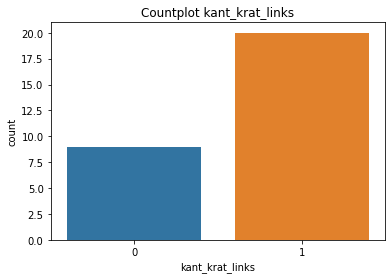

In [5]:
# Bepaal de mate van gebalanceerdheid van de dataset. Je kan hiervoor gebruik maken van de Seaborn countplot
# Bepaal ook de verhouding van het aantal samples van de twee verschillende klasses.



# gebalanceerdheid controleren
sns.countplot(data=dataset, x="kant_krat_links")
plt.title('Countplot kant_krat_links')


In [6]:
# Opsplitsen in features en targets

y = dataset['kant_krat_links'].values
X = dataset.drop(['kant_krat_links'], axis = 1).values

print(X.shape)
print(y.shape)


#1 lijst met 29 waarden, 7 features

(29, 7)
(29,)


In [7]:
# Opsplitsen in training set en test set. Zorg ervoor dat er 150 samples in de test set zitten.

# Opsplitsen/opdelen in training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1, random_state=0)

#training set
print(X_train.shape)

#test set
print(f'testdata:',X_test.shape)


(28, 7)
testdata: (1, 7)


In [8]:

# Normalisatie van de features

# Om conversion warning te vermijden:

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

# Normaliseren / scaling van de training set en de test set
scaler = StandardScaler() #scalen

#scalen met MinMax?
#scaler = preprocessing.MinMaxScaler().fit(X_train)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
X_train[1]

array([1.14460975, 1.55431889, 1.33568869, 1.1394964 , 1.55666379,
       1.42508439, 0.44995969])



              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
100.0


C:\Users\domin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


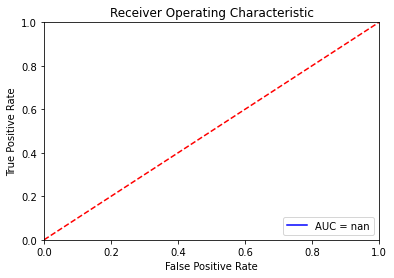

In [10]:
#Train zowel een logistic regression model als een Support Vector Machine via cross-validation.

#logistic regression (classweight balancing)


#Wanneer het aantal features groot is ten opzichte van het aantal training samples

model = LogisticRegression(C=1, solver='liblinear',class_weight='balanced')

# Trainen van het model

model.fit(X_train,y_train)

# Testen van het model

y_pred = model.predict(X_test)


print('\n')
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)

print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

# ROC
probs = model.predict_proba(X_test)
# calculate the fpr and tpr for all thresholds of the classification

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()






In [11]:
# Logistic regression (classweight balancing) 
#100

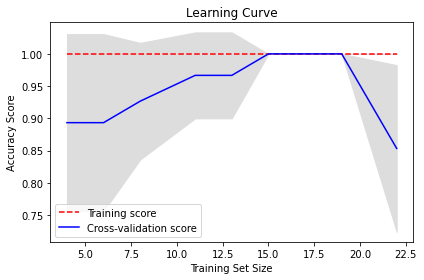

In [12]:
#Cross validation 

from sklearn.model_selection import learning_curve 

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(C=10000),
                                                        X_train, y_train,cv=5, scoring='accuracy',
                                                        n_jobs=-1,train_sizes=np.linspace(0.1, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="red",  label="Training score")
plt.plot(train_sizes, test_mean, color="blue", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [13]:
# Oversampling with SMOTE

#from imblearn.over_sampling import SMOTE
#X_resampled, y_resampled = SMOTE( k_neighbors=4, n_jobs=-1, m_neighbors=8).fit_resample(X_train, y_train)

#print(y_resampled.shape)

In [14]:
# Logistic regression with SMOTE

#werkt niet

In [15]:
# Support Vector Machine/SVM (Lineair)

SVMlinear = svm.SVC(kernel='linear',C=0.1, class_weight='balanced')
SVMlinear.fit(X_train, y_train)


SVC(C=0.1, class_weight='balanced', kernel='linear')

In [16]:
#SVM (lineair) model testen
y_pred = SVMlinear.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
100.0


In [17]:
#SVM (Lineair)
#Gridsearch: C = 0.1
#98.67  C = 0.1


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#model trainen
model = LogisticRegression()
paramaters = [
             {'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000,10000, 100000]}                                       
             ]
grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 5, # K = 20
                           n_jobs = -1,
                           verbose=5)
grid_search = grid_search.fit(X_train, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best accuracy :  0.96
Best parameters : {'C': 0.1}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
100.0


In [19]:
# Support Vector Machine/SVM (Met Kernel)
SVMkernel = svm.SVC(kernel='rbf',C=2.492356691610501,gamma=0.03595203735958652, class_weight='balanced')
#SVMkernel = svm.SVC(kernel='poly',C=1)
SVMkernel.fit(X_train, y_train)

SVC(C=2.492356691610501, class_weight='balanced', gamma=0.03595203735958652)

In [20]:

#SVM (met Kernel) model testen
y_pred = SVMkernel.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
100.0


In [21]:
#SVM met Kernel
#93.33 bij  C = 0.1 

#Gridsearch: C = 10, gamma = 0.01
#94.0  C = 10
#95.33 C = 10 gamma = 0.01

#Randomsearch: C = 2.492356691610501, gamma = 0.03595203735958652
#95.33  C = 2.492356691610501, gamma = 0.03595203735958652

In [22]:

#Gridsearch op SVM met Kernel
from sklearn.model_selection import GridSearchCV
#from sklearn.learning_curve import learning_curve
from sklearn.svm import SVC
#from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.model_selection import validation_curve

model = SVC()
paramaters = [ 
        {'kernel': ['linear'], 'C': np.linspace(1,20,100)},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2]},
        {'kernel': ['poly'], 'C':[1, 10]} ]
grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 5, # K
                           n_jobs = -1,
                           verbose = 4)
grid_search = grid_search.fit(X_train, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 5 folds for each of 112 candidates, totalling 560 fits
Best accuracy :  0.96
Best parameters : {'C': 1, 'gamma': 0.2, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
100.0


In [23]:
# Train een SVM via random search

from sklearn.model_selection import RandomizedSearchCV
# distributions
from scipy.stats import randint 
from scipy.stats import uniform



model = SVC(probability=True)
parameters = {'kernel': ['linear','rbf','poly'],
              'C': uniform(0.01, 20), # haal C uit een random uniform distribution
              'gamma': uniform(0.001, 0.2)}


n_iter_search = 20


random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 


# ROC
probs = grid_search.predict_proba(X_test)
# calculate the fpr and tpr for all thresholds of the classification

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best accuracy :  0.96
Best parameters : {'C': 0.8751529774846578, 'gamma': 0.17513445233299574, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
100.0


AttributeError: predict_proba is not available when  probability=False

In [ ]:
from sklearn.model_selection import learning_curve 

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(SVC(kernel='linear',C=1),
                                                        X_train, y_train,cv=5, scoring='accuracy',
                                                        n_jobs=-1,train_sizes=np.linspace(0.1, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="red",  label="Training score")
plt.plot(train_sizes, test_mean, color="blue", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Train zowel een logistic regression model als een Support Vector Machine via cross-validation.

Gebruik daarvoor zowel grid search, random search en eventueel Bayes optimization (indien werkende) om op zoek te gaan naar de beste hyperparameters: C-waarde, class_weight, etc. Meer info: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html. 

De Bayes optimzation uit de scikit-optimize (skopt) lijkt niet altijd meer te werken. Daarom kan je best gebruik maken van de optimzer te vinden op https://github.com/fmfn/BayesianOptimization.
Installatie hiervan kan via volgend commando in de command line:

`pip3 install git+https://github.com/darenr/scikit-optimize`
Indien deze BayesOptimization problemen geeft mag je deze stap van de opdracht overslaan.
    
Varieer bij K-fold cross-validation de waarde van K. Bespreek de resultaten.
Test de bekomen modellen op de test set. Welke search techniek geniet jouw voorkeur en waarom?
Heeft het zin om de featureset uit te breiden met polynomial features? Test dit. http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Bespreek telkens de bekomen resultaten in termen van de classificatiemetrics. Ga ook na of de modellen last lijken te hebben van niet-gebalanceerdheid.

In [ ]:
#Logistic regression(classweight-balancing): 98
#SVM (Linear/zonder kernel): 98.67
#SVM (met kernel): 95,33


# SVM met kernel lijkt last te hebben van niet-gebalanceerdheid
#aangezien het ook de grootste verschil heeft tussen zijn F1 score (0.97 en 0.93 (0.4 verschil))
#bij de andere modellen verschilt de onderlinge F1 score met 0.1


Stel dat de vereiste aan het model wordt gesteld dat de recall bij kwaadaardige tumoren minstens 99% moet zijn met behoud van een zo hoog mogelijk accuraatheid.
Onderzoek onderstaande mogelijkheden om aan deze vereiste te voldoen:
- Classweight balancing. Kijk eerst of class_weight='balanced' voldoende is. Indien niet, geeft zelf classweights mee met het model zodat toch aan de vereisten kan voldoen worden. Zowel logistic regression als Support Vector Machines ondersteunen deze classweight balancing.
- Onderzoek of undersampling/oversampling (via SMOTE) gebruikt kan worden om de vereiste te halen. Vermoedelijk moet je hiervoor nog de imbalanced-learn library installeren via `pip3 install imbalanced-learn`

- Threshold moving: verschuif de classificatie-threshold in het voordeel van de klasse kwaadaardig. Gebruik hiervoor enkel logistic regression. Gebruik de predict_proba values en de zelfgekozen threshold om te bepalen tot welke klasse een sample behoort. Kies deze threshold zorgvuldig zodat de recall voor de klasse kwaadaardig minstens 99% op de test set bedraagt maar de totale accuraatheid zo groot mogelijk blijft.

Bespreek de bekomen resultaten. Welke methode geniet hier jouw voorkeur en waarom?

In [ ]:
# Uitwerking
# add classweight-balancing
#bij SVM (met kernel) stijgt het van 95.33 naar 96.0 en recall van (1.00,0.86 -> 0.99,0.90)
#bij SVM lineair geen effect.

## Vraag 2. Patient survival prediction

De dataset `Patient_survival.csv` bevat gegevens over patienten in die opgenomen zijn in de intensive care unit (ICU) in verschillende ziekenhuizen. De kolom `hospital_death` geeft weer of een patient al dan niet gestorven is in het ziekenhuis.

De features zijn de volgende:
<br />

| Variable | Beschrijving |
| --- | --- | 
|encounter_id|Unique identifier associated with a patient unit stay. |
|patient_id|Unique identifier associated with a patient.|
|hospital_id |Unique identifier associated with a hospital. |
|age |The age of the patient on unit admission.|
|bmi |The body mass index of the person on unit admission.|
|elective_surgery |Whether the patient was admitted to the hospital for an elective surgical operation.|
|gender | Sex of the patient.|
|height| The height of the person on unit admission.|
|icu_id|A unique identifier for the unit to which the patient was admitted .|
|pre_icu_los_days|The length of stay of the patient between hospital admission and unit admission.|
|weight|The weight (body mass) of the person on unit admission.|
|apache_3j_diagnosis | The APACHE III-J sub-diagnosis code which best describes the reason for the ICU admission.|
|apache_post_operative|The APACHE operative status; 1 for post-operative, 0 for non-operative. |
|arf_apache|Whether the patient had acute renal failure during the first 24 hours of their unit stay, defined as a 24 hour urine output <410ml, creatinine >=133 micromol/L and no chronic dialysis.|
|gcs_eyes_apache|The eye opening component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score.|
|gcs_motor_apache| The motor component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score .|
|gcs_unable_apache|Whether the Glasgow Coma Scale was unable to be assessed due to patient sedation|
|gcs_verbal_apache|The verbal component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score |
|heart_rate_apache|The heart rate measured during the first 24 hours which results in the highest APACHE III score.|
|intubated_apache| Whether the patient was intubated at the time of the highest scoring arterial blood gas used in the oxygenation score.|
|map_apache|The mean arterial pressure measured during the first 24 hours which results in the highest APACHE III score|
|resprate_apache|The respiratory rate measured during the first 24 hours which results in the highest APACHE III score|
|temp_apache|The temperature measured during the first 24 hours which results in the highest APACHE III score|
|ventilated_apache|Whether the patient was invasively ventilated at the time of the highest scoring arterial blood gas using the oxygenation scoring algorithm, including any mode of positive pressure ventilation delivered through a circuit attached to an endo-tracheal tube or tracheostomy.|
|d1_diasbp_max|The patient's highest diastolic blood pressure during the first 24 hours of their unit stay, either non-invasively or invasively measured.|
|d1_diasbp_min|The patient's lowest diastolic blood pressure during the first 24 hours of their unit stay, either non-invasively or invasively measured|
|d1_diasbp_noninvasive_max|The patient's highest diastolic blood pressure during the first 24 hours of their unit stay, non-invasively measured.|
|d1_diasbp_noninvasive_min|The patient's lowest diastolic blood pressure during the first 24 hours of their unit stay, non-invasively measured.|
|d1_heartrate_max|The patient's highest heart rate during the first 24 hours of their unit stay|
|d1_heartrate_min|The patient's lowest heart rate during the first 24 hours of their unit stay|
|d1_mbp_max|The patient's highest mean blood pressure during the first 24 hours of their unit stay, either non-invasively or invasively measured|
|d1_mbp_min|The patient's lowest mean blood pressure during the first 24 hours of their unit stay, either non-invasively or invasively measured|
|d1_mbp_noninvasive_max | The patient's highest mean blood pressure during the first 24 hours of their unit stay, non-invasively measured|
|d1_mbp_noninvasive_min | The patient's lowest mean blood pressure during the first 24 hours of their unit stay, non-invasively measured|
|d1_resprate_max|The patient's highest respiratory rate during the first 24 hours of their unit stay|
|d1_resprate_min|The patient's lowest respiratory rate during the first 24 hours of their unit stay|
|d1_spo2_max|The patient's highest peripheral oxygen saturation during the first 24 hours of their unit stay|
|d1_spo2_min|The patient's lowest peripheral oxygen saturation during the first 24 hours of their unit stay|
|d1_sysbp_max|The patient's highest systolic blood pressure during the first 24 hours of their unit stay, either non-invasively or invasively measured|
|d1_sysbp_min|The patient's lowest systolic blood pressure during the first 24 hours of their unit stay, either non-invasively or invasively measured|
|d1_sysbp_noninvasive_max|The patient's highest systolic blood pressure during the first 24 hours of their unit stay, invasively measured|
|d1_sysbp_noninvasive_min|The patient's lowest systolic blood pressure during the first 24 hours of their unit stay, invasively measured
|d1_temp_max|The patient's highest core temperature during the first 24 hours of their unit stay, invasively measured
|d1_temp_min|The patient's lowest core temperature during the first 24 hours of their unit stay
|h1_diasbp_max|The patient's highest diastolic blood pressure during the first hour of their unit stay, either non-invasively or invasively measured|
|h1_diasbp_min|The patient's lowest diastolic blood pressure during the first hour of their unit stay, either non-invasively or invasively measured|
|h1_diasbp_noninvasive_max|The patient's highest diastolic blood pressure during the first hour of their unit stay, invasively measured|
|h1_diasbp_noninvasive_min|The patient's lowest diastolic blood pressure during the first hour of their unit stay, invasively measured|
|h1_heartrate_max|The patient's highest heart rate during the first hour of their unit stay|
|h1_heartrate_min|The patient's lowest heart rate during the first hour of their unit stay|
|h1_mbp_max|The patient's highest mean blood pressure during the first hour of their unit stay, either non-invasively or invasively measured|
|h1_mbp_min|The patient's lowest mean blood pressure during the first hour of their unit stay, either non-invasively or invasively measured|
|h1_mbp_noninvasive_max|The patient's highest mean blood pressure during the first hour of their unit stay, non-invasively measured|
|h1_mbp_noninvasive_min|The patient's lowest mean blood pressure during the first hour of their unit stay, non-invasively measured|
|h1_resprate_max|The patient's highest respiratory rate during the first hour of their unit stay|
|h1_resprate_min|The patient's lowest respiratory rate during the first hour of their unit stay|
|h1_spo2_max|The patient's highest peripheral oxygen saturation during the first hour of their unit stay|
|h1_spo2_min|The patient's lowest peripheral oxygen saturation during the first hour of their unit stay|
|h1_sysbp_max|The patient's highest systolic blood pressure during the first hour of their unit stay, either non-invasively or invasively measured|
|h1_sysbp_min|The patient's lowest systolic blood pressure during the first hour of their unit stay, either non-invasively or invasively measured|
|h1_sysbp_noninvasive_max|The patient's highest systolic blood pressure during the first hour of their unit stay, non-invasively measured|
|h1_sysbp_noninvasive_min|The patient's lowest systolic blood pressure during the first hour of their unit stay, non-invasively measured|
|d1_glucose_max|The highest glucose concentration of the patient in their serum or plasma during the first 24 hours of their unit stay
|d1_glucose_minThe lowest glucose concentration of the patient in their serum or plasma during the first 24 hours of their unit stay
d1_potassium_max|The highest potassium concentration for the patient in their serum or plasma during the first 24 hours of their unit stay
d1_potassium_min|The lowest potassium concentration for the patient in their serum or plasma during the first 24 hours of their unit stay
apache_4a_hospital_death_prob|The APACHE IVa probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.
apache_4a_icu_death_prob|The APACHE IVa probabilistic prediction of in ICU mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis
aids|Whether the patient has a definitive diagnosis of acquired immune deficiency syndrome (AIDS) (not HIV positive alone)
|cirrhosis|Whether the patient has a history of heavy alcohol use with portal hypertension and varices, other causes of cirrhosis with evidence of portal hypertension and varices, or biopsy proven cirrhosis. This comorbidity does not apply to patients with a functioning liver transplant.
diabetes_mellitus|Whether the patient has been diagnosed with diabetes, either juvenile or adult onset, which requires medication.
hepatic_failure|Whether the patient has cirrhosis and additional complications including jaundice and ascites, upper GI bleeding, hepatic encephalopathy, or coma.
immunosuppression|Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).
leukemia
lymphoma|Whether the patient has been diagnosed with non-Hodgkin lymphoma.
solid_tumor_with_metastasis|Whether the patient has been diagnosed with any solid tumor carcinoma (including malignant melanoma) which has evidence of metastasis.
apache_3j_bodysystem|Admission diagnosis group for APACHE III
Unnamed: 83|?
hospital_death|Whether the patient died during this hospitalization 
|





De bedoeling is om een zo classifier (logistic regression of SVM) te trainen die zo goed mogelijk kan voorspellen of een patient al dan niet zal sterven na opname in de ICU.

Doorloop volgende stappen:

- Contoleer de gebalanceerheid van de dataset. Wat is de verhouding van de twee klasses?
- Verwijder er 'id'-featurs die verwijdert kunnen worden?
- Zijn er overbodige features die verwijdert kunnen worden?
- Verwijder rijen die ontbrekende waarden bevat.
- Verander categorische variabelen naar numerieke variabelen. Dit kan door binaire categorieën om te zetten naar 1/0 en door one-hot encoding toe te passen daar waar meerdere categorieën aanwezig zijn.
- Splits op in features en targets en vervolgens in een training set en test set. Zorg voor een test set met 20% van de samples. Scale de dataset.
- Train een logistic regression model en SVM. Dit mag onmiddellijk via cross-validatie gebeuren.
- Onderzoek in welke mate het model last heeft van de ongebalanceerdheid van de dataset.
- Teken de ROC-curve. Kan je hieruit aflezen of de classifier al dan niet last heeft van niet-gebalanceerd.
- Teken nu ook de Precision-Recall curve. Wat kan je hieruit besluiten?
- De klant wil graag een model dat een macro_f1 score haalt op de test set die zo hoog mogelijk ligt (liefst hoger ligt dan 70%). Bekijk nu opnieuw de ROC-curve en de Precision-Recall curve. Wat kan je besluiten?
- Onderzoek of je door het weglaten van bepaalde features betere resultaten haalt. 

### OPMERKING

Omwille van de omvang de dataset kan het trainen van de modellen bijzonder intensief zijn. Daarom is het toegestaan om de training set (drastisch) te verkleinen.
Het kan wel zijn dat de performantie van het model daalt wanneer je minder training dat gebruikt. In dat geval kan het zijn dat een macro_f1 score van 70% niet haalbaar is. Probeer dan een zo hoog mogelijke macro_f1 score te bekomen.

In [24]:
dataset = pd.read_csv('TestData.csv')
dataset.head(50)

,PartitionKey,RowKey,Timestamp,RackRow,RackRow@type,Label,Label@type,WeightPre,WeightPre@type,WeightPost,WeightPost@type,WeightDiff,WeightDiff@type,DistMinH,DistMinH@type,DistMaxH,DistMaxH@type,DistAvgH,DistAvgH@type,DistMinL,DistMinL@type,DistMaxL,DistMaxL@type,DistAvgL,DistAvgL@type,DistTime,DistTime@type
0,F0:08:D1:C8:A7:34,06e05b50-bcbf-4fad-a713-c19975ef4b42,2022-05-25T13:16:47.9637282Z,2,Int32,3,Int32,0,Int32,0,Int32,0,Int32,27,Int32,29,Int32,28,Int32,27,Int32,29,Int32,28,Int32,207,Int32
1,F0:08:D1:C8:A7:34,0cffb11c-0506-4d8d-8cad-7f2d00053380,2022-05-25T13:15:19.5884474Z,2,Int32,2,Int32,0,Int32,0,Int32,0,Int32,32,Int32,34,Int32,33,Int32,32,Int32,34,Int32,33,Int32,1136,Int32
2,F0:08:D1:C8:A7:34,11090373-a998-47a1-b8c3-807b4c036d53,2022-05-25T13:17:16.801118Z,2,Int32,6,Int32,0,Int32,0,Int32,0,Int32,9,Int32,10,Int32,9,Int32,9,Int32,15,Int32,11,Int32,513,Int32
3,F0:08:D1:C8:A7:34,13f3867e-2b06-43a9-8843-e3f5245cf925,2022-05-25T13:20:12.9485555Z,2,Int32,21,Int32,0,Int32,0,Int32,0,Int32,29,Int32,30,Int32,29,Int32,29,Int32,30,Int32,29,Int32,765,Int32
4,F0:08:D1:C8:A7:34,275027a4-b73f-484f-916b-ba69df4b65c4,2022-05-25T13:21:42.5068964Z,2,Int32,5,Int32,0,Int32,0,Int32,0,Int32,12,Int32,16,Int32,14,Int32,12,Int32,16,Int32,14,Int32,1135,Int32
5,F0:08:D1:C8:A7:34,397b206d-120f-41b2-875d-5aeb20a71121,2022-05-25T13:20:50.1554834Z,2,Int32,24,Int32,0,Int32,0,Int32,0,Int32,9,Int32,12,Int32,10,Int32,9,Int32,12,Int32,10,Int32,574,Int32
6,F0:08:D1:C8:A7:34,4a24c5c6-e4f8-4cff-860c-2f8d754e581b,2022-05-25T13:19:04.2714384Z,2,Int32,15,Int32,0,Int32,0,Int32,0,Int32,27,Int32,29,Int32,27,Int32,27,Int32,29,Int32,27,Int32,393,Int32
7,F0:08:D1:C8:A7:34,578c8377-49cf-481b-b234-77900570a574,2022-05-25T13:14:52.8453005Z,2,Int32,1,Int32,0,Int32,0,Int32,0,Int32,37,Int32,37,Int32,37,Int32,37,Int32,37,Int32,37,Int32,25,Int32
8,F0:08:D1:C8:A7:34,666f1a7f-25ef-4638-91cb-fd561b596359,2022-05-25T13:21:15.7140073Z,2,Int32,2,Int32,0,Int32,0,Int32,0,Int32,32,Int32,35,Int32,33,Int32,32,Int32,35,Int32,33,Int32,584,Int32
9,F0:08:D1:C8:A7:34,712dd309-c888-45d3-8997-234eb473d2d1,2022-05-25T13:19:43.1138419Z,2,Int32,19,Int32,0,Int32,0,Int32,0,Int32,39,Int32,41,Int32,40,Int32,39,Int32,41,Int32,40,Int32,766,Int32


In [25]:
# verwijder kollomen die niet relevant zijn met model (id's,types)
dataset.drop(['PartitionKey','Timestamp','RackRow','RowKey'],axis=1,inplace=True)
dataset.drop('RackRow@type',axis=1,inplace=True)
dataset.drop('Label',axis=1,inplace=True)
dataset.drop('Label@type',axis=1,inplace=True)

# verwijder kollomen weight 
dataset.drop(['WeightPre','WeightPre@type','WeightPost','WeightPost@type', 'WeightDiff','WeightDiff@type'],axis=1,inplace=True)


#verwijder kollomen distance
dataset.drop(['DistMinH@type','DistMaxH@type','DistAvgH@type','DistMinL@type', 'DistMaxL@type','DistAvgL@type', 'DistTime@type'],axis=1,inplace=True)


#one hot encoding
# dataset = pd.concat([dataset,pd.get_dummies(dataset['RowKey'], prefix='RowKey')],axis=1)
# dataset.drop(['RowKey'],axis=1, inplace=True)



dataset.head(10)

,DistMinH,DistMaxH,DistAvgH,DistMinL,DistMaxL,DistAvgL,DistTime
0,27,29,28,27,29,28,207
1,32,34,33,32,34,33,1136
2,9,10,9,9,15,11,513
3,29,30,29,29,30,29,765
4,12,16,14,12,16,14,1135
5,9,12,10,9,12,10,574
6,27,29,27,27,29,27,393
7,37,37,37,37,37,37,25
8,32,35,33,32,35,33,584
9,39,41,40,39,41,40,766


In [26]:
# Toevoegen van 'kant_krat_links' kolom op basis van DistAvgL
dataset.insert(0,'kant_krat_links', dataset['DistAvgL'])

#DistAvgL waarden

dataset['kant_krat_links'].values[dataset['DistAvgL'] < 20] = 0
dataset['kant_krat_links'].values[dataset['DistAvgL'] >= 20] = 1

dataset.head(10)

,kant_krat_links,DistMinH,DistMaxH,DistAvgH,DistMinL,DistMaxL,DistAvgL,DistTime
0,1,27,29,28,27,29,28,207
1,1,32,34,33,32,34,33,1136
2,0,9,10,9,9,15,11,513
3,1,29,30,29,29,30,29,765
4,0,12,16,14,12,16,14,1135
5,0,9,12,10,9,12,10,574
6,1,27,29,27,27,29,27,393
7,1,37,37,37,37,37,37,25
8,1,32,35,33,32,35,33,584
9,1,39,41,40,39,41,40,766


Text(0.5, 1.0, 'Countplot kant_krat_links')

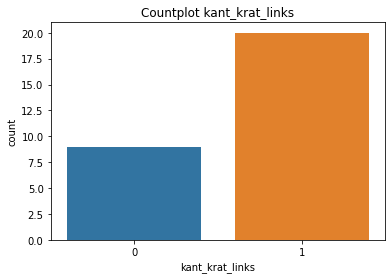

In [27]:
# Uitwerking
# gebalanceerdheid controleren
sns.countplot(data=dataset, x="kant_krat_links")
plt.title('Countplot kant_krat_links')


In [28]:
# Correlation plot
#Corr=dataset[dataset.columns].corr() 
#sns.heatmap(Corr, annot=True)

In [29]:
# Opsplitsen in features en targets

y = dataset['kant_krat_links'].values
X = dataset.drop(['kant_krat_links'], axis = 1).values

print(X.shape)
print(y.shape)


#1 lijst met 568 waarden, 30 features

(29, 7)
(29,)


In [30]:
# Opsplitsen in training set en test set. Zorg ervoor dat er 20% samples in de test set zitten.

# Opsplitsen/opdelen in training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

#training set
print(X_train.shape)

#test set
print(f'testdata:',X_test.shape)

(23, 7)
testdata: (6, 7)


In [31]:

# Normalisatie van de features

# Om conversion warning te vermijden:

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

# Normaliseren / scaling van de training set en de test set
scaler = StandardScaler() #scalen

#scalen met MinMax?
#scaler = preprocessing.MinMaxScaler().fit(X_train)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
X_train[1]

array([-0.09298544,  0.6882472 ,  0.38512062, -0.1082759 ,  0.67421546,
        0.36906927,  1.74262306])



              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[[2 0]
 [0 4]]
100.0


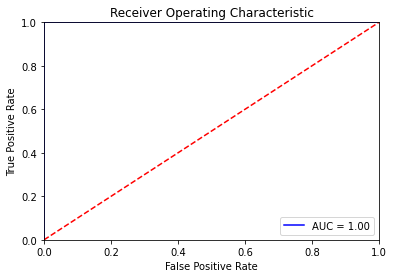

In [33]:
#Train zowel een logistic regression model als een Support Vector Machine via cross-validation.

#logistic regression (classweight balancing)


#Wanneer het aantal features groot is ten opzichte van het aantal training samples

model = LogisticRegression(C=1, solver='liblinear',class_weight='balanced')

# Trainen van het model

model.fit(X_train,y_train)

# Testen van het model

y_pred = model.predict(X_test)


print('\n')
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)

print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

# ROC
probs = model.predict_proba(X_test)
# calculate the fpr and tpr for all thresholds of the classification

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [34]:
# Logistic regression (classweight balancing) 
#100 met StandardScaler 

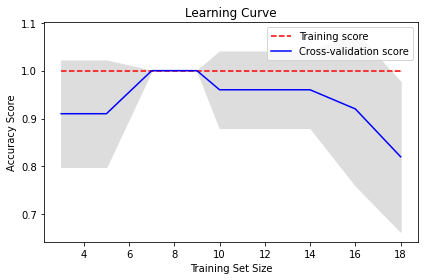

In [35]:
#Cross validation 

from sklearn.model_selection import learning_curve 

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(C=10000),
                                                        X_train, y_train,cv=5, scoring='accuracy',
                                                        n_jobs=-1,train_sizes=np.linspace(0.1, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="red",  label="Training score")
plt.plot(train_sizes, test_mean, color="blue", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [36]:
# Support Vector Machine/SVM (Lineair)

SVMlinear = svm.SVC(kernel='linear',C=1, class_weight='balanced')
SVMlinear.fit(X_train, y_train)


SVC(C=1, class_weight='balanced', kernel='linear')

In [37]:
#SVM (lineair) model testen
y_pred = SVMlinear.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[[2 0]
 [0 4]]
100.0


In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#model trainen
model = LogisticRegression()
paramaters = [
             {'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000,10000, 100000]}                                       
             ]
grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 5, # K = 20
                           n_jobs = -1,
                           verbose=5)
grid_search = grid_search.fit(X_train, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best accuracy :  0.95
Best parameters : {'C': 0.1}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[[2 0]
 [0 4]]
100.0


In [39]:
# Support Vector Machine/SVM (Met Kernel)
SVMkernel = svm.SVC(kernel='rbf',C=1.132819667784778,gamma=0.01, class_weight='balanced')
#SVMkernel = svm.SVC(kernel='poly',C=1)
SVMkernel.fit(X_train, y_train)

SVC(C=1.132819667784778, class_weight='balanced', gamma=0.01)

In [40]:

#SVM (met Kernel) model testen
y_pred = SVMkernel.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[[2 0]
 [0 4]]
100.0


In [41]:
#SVM met kernel en C,gamma= 0.1 ~ 18 accuracy
#SVM met kernel en C,gamma = 0.01 ~ 76 accuracy
#SVM met kernel en C,gamma = 0.001 ~  9 accuracy

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best accuracy :  0.95
Best parameters : {'C': 7.151913525024739, 'gamma': 0.15301399469982735, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[[2 0]
 [0 4]]
100.0


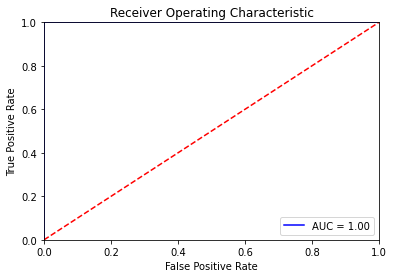

In [42]:
# Train een SVM via random search

from sklearn.model_selection import RandomizedSearchCV
# distributions
from scipy.stats import randint 
from scipy.stats import uniform



model = SVC(probability=True)
parameters = {'kernel': ['linear','rbf','poly'],
              'C': uniform(0.01, 20), # haal C uit een random uniform distribution
              'gamma': uniform(0.001, 0.2)}


n_iter_search = 20


random_search = RandomizedSearchCV(model, param_distributions=parameters,cv=5,n_iter=n_iter_search,n_jobs = -1,verbose=1)

random_search = random_search.fit(X_train, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :',random_search.best_params_  )

y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 


# ROC
probs = grid_search.predict_proba(X_test)
# calculate the fpr and tpr for all thresholds of the classification

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [43]:

#Gridsearch op SVM met Kernel
from sklearn.model_selection import GridSearchCV
#from sklearn.learning_curve import learning_curve
from sklearn.svm import SVC
#from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.model_selection import validation_curve

model = SVC()
paramaters = [ 
        {'kernel': ['linear'], 'C': np.linspace(1,20,100)},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2]},
        {'kernel': ['poly'], 'C':[1, 10]} ]
grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 2, # K
                           n_jobs = -1,
                           verbose = 4)
grid_search = grid_search.fit(X_train, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

Fitting 2 folds for each of 112 candidates, totalling 224 fits
Best accuracy :  0.9545454545454546
Best parameters : {'C': 10, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[[2 0]
 [0 4]]
100.0
